In [1]:
import iris
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ncfile = ('http://geoport.whoi.edu/thredds/dodsC/usgs/vault0/models/tides/'
              'vdatum_gulf_of_maine/adcirc54_38_orig.nc')
    cubes = iris.load_raw(ncfile)

print(cubes)

0: longitude / (degrees)               (-- : 166131)
1: Tide Constituent / (no_unit)        (-- : 38; -- : 64)
2: Horizontal Element Incidence List / (1) (-- : 308259; -- : 3)
3: Northward Water Velocity Phase / (unknown) (Depth-Averaged Output in the Vertical: 1; -- : 166131; -- : 38)
4: depth / (meters)                    (-- : 166131)
5: latitude / (degrees)                (-- : 166131)
6: Eastward Water Velocity Phase / (unknown) (Depth-Averaged Output in the Vertical: 1; -- : 166131; -- : 38)
7: Northward Water Velocity Amplitude / (m/s) (Depth-Averaged Output in the Vertical: 1; -- : 166131; -- : 38)
8: Tide Frequency / (radians/second)   (-- : 38)
9: Eastward Water Velocity Amplitude / (m/s) (Depth-Averaged Output in the Vertical: 1; -- : 166131; -- : 38)


In [2]:
units = dict({'knots': 1.9438, 'm/s': 1.0})
consts = ['STEADY', 'M2', 'S2', 'N2', 'K1', 'O1', 'M4', 'M6']

bbox = [-70.7234, -70.4532, 41.4258, 41.5643]
cax = [0.0, 3.0]  # in units selected above.
vscale = [0.005]  # Velocity vector scale (try 0.01 and then perhaps adjust).

# SELECT: location of color legend on page
clegend_loc = [0.96, 0.35, 0.02, 0.5]

xoff = yoff = 0.0
sta = [-70.7299, 41.5224]  # Station to plot on map.

halo = 0.1
ax2 = [bbox[0] - halo * (bbox[1] - bbox[0]),
       bbox[1] + halo * (bbox[1] - bbox[0]),
       bbox[2] - halo * (bbox[3] - bbox[2]),
       bbox[3] + halo * (bbox[3] - bbox[2])]

In [3]:
import pytz
from datetime import datetime
from pandas import date_range


start = datetime.strptime('18-Sep-2015 05:00',
                          '%d-%b-%Y %H:%M').replace(tzinfo=pytz.utc)
stop = datetime.strptime('18-Sep-2015 18:00',
                         '%d-%b-%Y %H:%M').replace(tzinfo=pytz.utc)

dt = 1.0  # Hours.

glocals = date_range(start, stop, freq='1H').to_pydatetime()

ntimes = len(glocals)

In [4]:
def parse_string(name):
    return ''.join(name.tolist()).strip()


names = []
data = cubes.extract_strict('Tide Constituent').data
for name in data:
    names.append(parse_string(name))

In [5]:
from scipy.spatial import Delaunay

depth = cubes.extract_strict('depth').data
latf = cubes.extract_strict('latitude').data
lonf = cubes.extract_strict('longitude').data
frequency = cubes.extract_strict('Tide Frequency').data

# Not sure why this is not working.
# trif = cubes.extract_strict('Horizontal Element Incidence List').data
trif = Delaunay(zip(lonf, latf)).vertices

In [6]:
# Find indices in box.
import numpy as np


inbox = np.logical_and(np.logical_and(lonf >= ax2[0],
                                      lonf <= ax2[1]),
                       np.logical_and(latf >= ax2[2],
                                      latf <= ax2[3]))

lon = lonf[inbox]
lat = latf[inbox]

In [7]:
import os.path
from scipy.io import loadmat

mat = os.path.join('..', 't_tide_v1.3beta', 't_constituents.mat')
con_info = loadmat(mat, squeeze_me=True)
con_info = con_info['const']  # I am ignore shallow water and sat constants!

In [8]:
# Find the indices of the tidal constituents.

k = 0
ind_nc, ind_ttide = [], []

const_name = [e.strip() for e in con_info['name'].tolist()]

for name in consts:
    try:
        if name == 'STEADY':
            indx = const_name.index('Z0')
        else:
            indx = const_name.index(name)
        k += 1
        ind_ttide.append(indx)
        ind_nc.append(names.index(name))
    except ValueError:
        pass  # `const` not found.

In [9]:
ua = cubes.extract_strict('Eastward Water Velocity Amplitude')
up = cubes.extract_strict('Eastward Water Velocity Phase')
va = cubes.extract_strict('Northward Water Velocity Amplitude')
vp = cubes.extract_strict('Northward Water Velocity Phase')

In [10]:
uamp = ua.data[0, inbox, :][:, ind_nc]
vamp = va.data[0, inbox, :][:, ind_nc]
upha = up.data[0, inbox, :][:, ind_nc]
vpha = vp.data[0, inbox, :][:, ind_nc]

In [11]:
freq_nc = frequency[ind_nc]

This is messed up!  You execute `.tolist()` on a 0-d array containing an
array and you get an array!

In [12]:
freq = con_info['freq'].tolist()

freq_ttide = freq[ind_ttide]

In [13]:
t_tide_names = np.array(const_name)[ind_ttide]

In [14]:
omega_ttide = 2*np.pi * freq_ttide  # Convert from radians/s to radians/hour.

omega = freq_nc * 3600

rllat = 55  # Reference latitude for 3rd order satellites (degrees) (55 is fine always)

In [15]:
#  I could not get this to work.  Using octave and MatlabTM t_tide instead.
from ttide.t_vuf import t_vuf
help(t_vuf)

Help on function t_vuf in module ttide.t_vuf:

t_vuf(ltype, ctime, ju, lat=None)
    T_VUF Computes nodal modulation corrections.
    [V,U,F]=T_VUF(TYPE,DATE,JU,LAT) returns the astronomical phase V, the 
    nodal phase modulation U, and the nodal amplitude correction F at
    a decimal date DATE for the components specified by index JU 
    at a latitude LAT.
    
    TYPE is either 'full' for the 18.6 year set of constitunets, or 'nodal'
    for the 1-year set with satellite modulations.
    
    If LAT is not specified, then the Greenwich phase V is computed with
    U=0 and F=1. 
    
    Note that V and U are in 'cycles', not degrees or radians (i.e.,
    multiply by 360 to get degrees).
    
    If LAT is set to NaN, then the nodal corrections are computed for all
    satellites that do *not* have a "latitude-dependent" correction 
    factor. This is for compatibility with the ways things are done in
    the xtide package. (The latitude-dependent corrections were zeroed
    out

In [16]:
from matplotlib.dates import date2num

jd_start = date2num(start) + 366.1667 # to_MatlabTM.

ind_ttide = np.array(ind_ttide) + 1  # to_MatlabTM.

In [17]:
%load_ext oct2py.ipython

In [18]:
%%octave -i jd_start,ind_ttide,rllat -o v,u,f

pkg load all
addpath(genpath('../t_tide_v1.3beta/'))

[v, u, f] = t_vuf('nodal', jd_start, ind_ttide, rllat);

/home/filipe/.virtualenvs/iris/lib/python2.7/site-packages/oct2py/core.py:832: UserWarning: Oct2Py may not be able to display plots properly without gnuplot, please install it (gnuplot-x11 on Linux)
  warnings.warn('Oct2Py may not be able to display plots '


In [19]:
# Convert phase in radians.
v, u, f = map(np.squeeze, (v, u, f))
v = v * 2 * np.pi
u = u * 2 * np.pi

thours = np.array([d.total_seconds() for d in
                   (glocals - glocals[0])]) / 60 / 60.


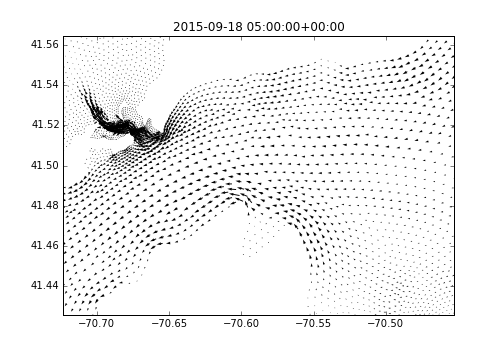
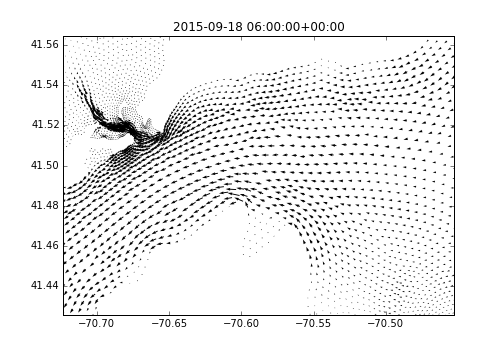
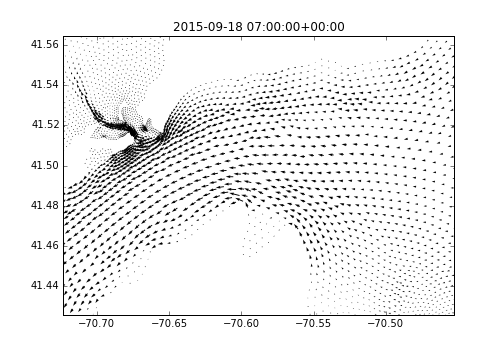
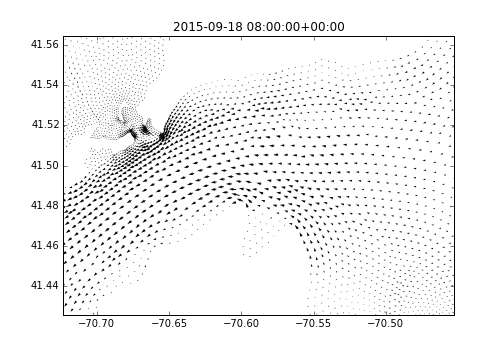
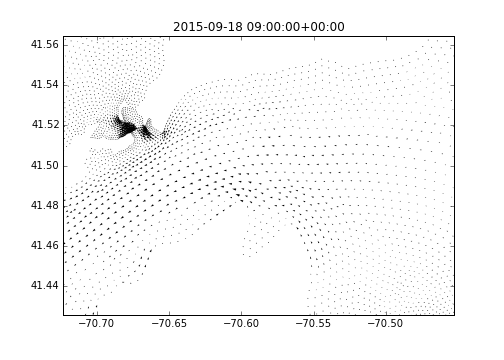
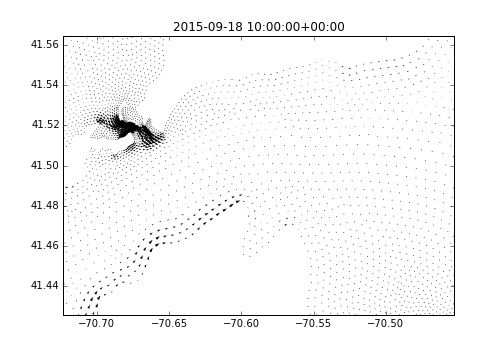
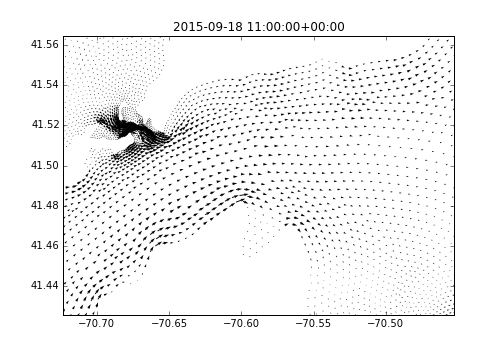
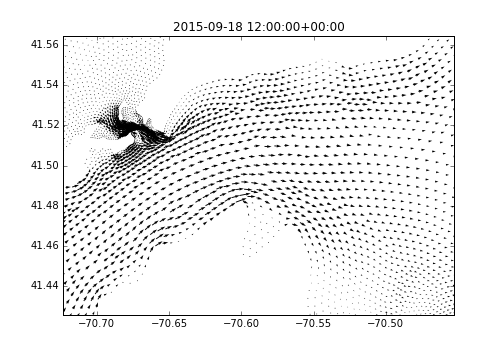
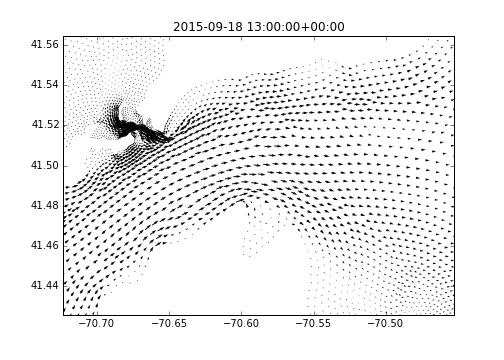
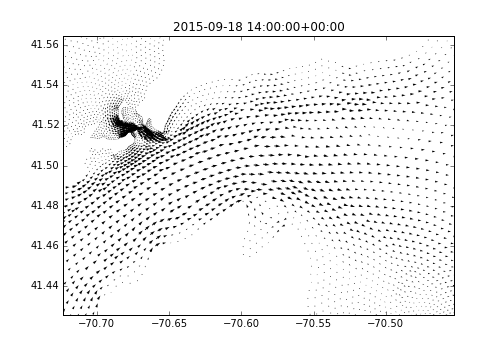
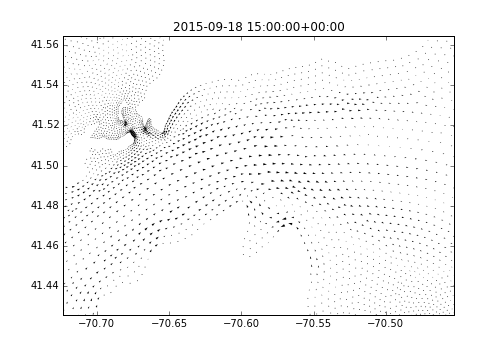
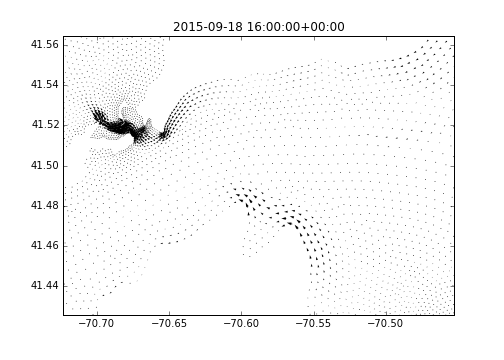
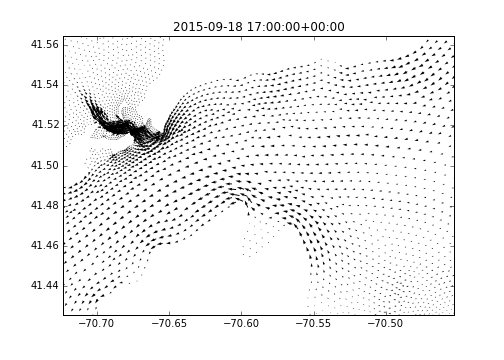
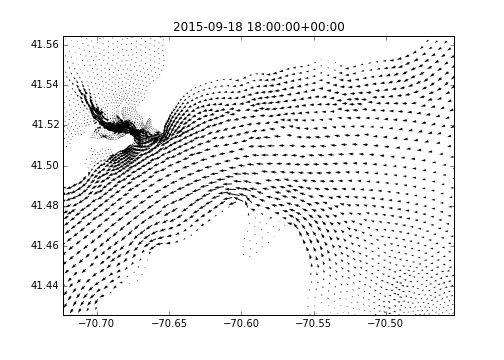

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
from JSAnimation import IPython_display
from matplotlib.animation import FuncAnimation

def update_figure(k):
    global ax, fig
    ax.cla()
    
    U = (f * uamp * np.cos(v + thours[k] * omega + u - upha * np.pi/180)).sum(axis=1)
    V = (f * vamp * np.cos(v + thours[k] * omega + u - vpha * np.pi/180)).sum(axis=1)
    
    w = units['knots'] * (U + 1j * V)
    
    wf = np.NaN * np.ones_like(lonf, dtype=w.dtype)
    wf[inbox] = w

    # FIXME: Cannot use masked arrays and tricontour!
    # wf = ma.masked_invalid(wf)
    # cs = ax.tricontour(lonf, latf, trif, np.abs(wf).filled(fill_value=0))
    # fig.colorbar(cs)
    q = ax.quiver(lon, lat, U, V, scale=60)
    ax.axis(bbox)  # Vineyard sound 2.
    ax.set_title('{}'.format(glocals[k]))

fig, ax = plt.subplots(figsize=(7, 5))
FuncAnimation(fig, update_figure, interval=100, frames=ntimes)